In [1]:
#!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
#!pip3 install torchvision

# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
print('P0 Done')

P0 Done


In [0]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import numpy as np
import time
import datetime

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def plot_kernel(model):
    model_weights = model.state_dict()
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(model_weights['conv1.weight']):
    #print(filt[0, :, :])
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :], cmap="gray")
        plt.axis('off')
    
    plt.show()

def plot_kernel_output(model,images):
    fig1 = plt.figure()
    plt.figure(figsize=(1,1))
    
    img_normalized = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(img_normalized.numpy().transpose(1,2,0))
    plt.show()
    output = model.conv1(images)
    layer_1 = output[0, :, :, :]
    layer_1 = layer_1.data

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(layer_1):
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show()

def test_accuracy(net, dataloader):
  ########TESTING PHASE###########
  
    #check accuracy on whole test set
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (
    accuracy))
    return accuracy

    
n_classes = 100 
# function to define an old style fully connected network (multilayer perceptrons)
class old_nn(nn.Module):
    def __init__(self):
        super(old_nn, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
      
      
#function to define the convolutional network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, stride=2, padding=0)
        self.conv1_bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.conv_final_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 4096)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(4096, n_classes) 

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.pool(self.conv_final_bn(self.conv_final(x))))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [3]:

      ####RUNNING CODE FROM HERE:
print('Loading data...')      
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
        #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=4,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=4,drop_last=True)


dataiter = iter(trainloader)

print('Loading done')


Loading data...
Files already downloaded and verified
Files already downloaded and verified
Loading done


In [4]:
###OPTIONAL:
# show images just to understand what is inside the dataset ;)
#images, labels = dataiter.next()
#imshow(torchvision.utils.make_grid(images))
####


#create the old style NN network
#net = old_nn()
###

net = CNN()
####
#for Residual Network:
#net = models.resnet18(pretrained=True)
#net.fc = nn.Linear(512, n_classes) #changing the fully connected layer of the already allocated network
####

###OPTIONAL:
#print("####plotting kernels of conv1 layer:####")
#plot_kernel(net)
####


net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

###OPTIONAL:
#print("####plotting output of conv1 layer:#####")
#plot_kernel_output(net,images)  
###
print('Ready to train')

Ready to train


In [5]:
########TRAINING PHASE###########
t0 = time.time()
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!
n_epochs = 20
accus = np.empty(n_epochs)
losses = np.empty(n_epochs)
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_loss_print))
            losses[epoch] = running_loss / n_loss_print
            running_loss = 0.0
    accus[epoch] = test_accuracy(net,testloader)
print('Finished Training in '+str(datetime.timedelta(seconds = time.time()-t0))+' seconds')


[1,   195] loss: 3.787
Accuracy of the network on the test set: 21 %
[2,   195] loss: 3.096
Accuracy of the network on the test set: 28 %
[3,   195] loss: 2.754
Accuracy of the network on the test set: 32 %
[4,   195] loss: 2.499
Accuracy of the network on the test set: 36 %
[5,   195] loss: 2.310
Accuracy of the network on the test set: 37 %
[6,   195] loss: 2.148
Accuracy of the network on the test set: 39 %
[7,   195] loss: 2.008
Accuracy of the network on the test set: 41 %
[8,   195] loss: 1.883
Accuracy of the network on the test set: 42 %
[9,   195] loss: 1.758
Accuracy of the network on the test set: 43 %
[10,   195] loss: 1.636
Accuracy of the network on the test set: 44 %
[11,   195] loss: 1.529
Accuracy of the network on the test set: 45 %
[12,   195] loss: 1.417
Accuracy of the network on the test set: 45 %
[13,   195] loss: 1.311
Accuracy of the network on the test set: 45 %
[14,   195] loss: 1.207
Accuracy of the network on the test set: 45 %
[15,   195] loss: 1.107
Accur

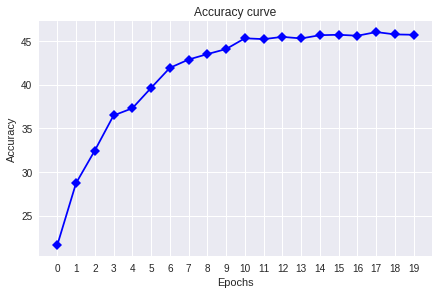

In [6]:
plt.plot(accus, label='Accuracy', marker='D', color='blue')
plt.title('Accuracy curve')
plt.tight_layout()
plt.xticks(np.arange(0, n_epochs, step=1))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()



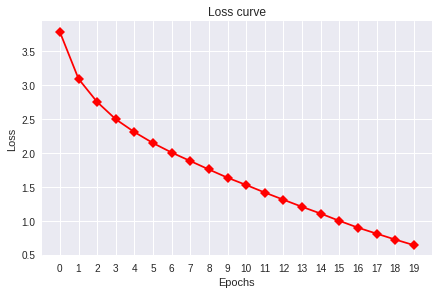

In [7]:
plt.plot(losses, label='Loss',marker='D',color='red')
plt.title('Loss curve')
plt.tight_layout()
plt.xticks(np.arange(0, n_epochs, step=1))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()